In [1]:
# Import dependencies

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Import dependencies

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
# Create engine to hawaii.sqlite

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# Reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect = True)

In [5]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB

session = Session(engine)

In [8]:
# Inspect the table

inspector = inspect(engine)

In [9]:
# Inspect the table measurement

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Inspect the table station

columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set

recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23')

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

last_twelve_months = dt.datetime.strptime(recent_date[0], '%Y-%m-%d') - dt.timedelta(days = 365)

In [24]:
# Perform a query to retrieve the date and precipitation scores

sel = [Measurement.date, Measurement.prcp]
date_prcp = session.query(*sel).filter(Measurement.date >= last_twelve_months)

In [25]:
# Save the query results as a Pandas DataFrame and set the index to the date column

date_prcp_df = pd.DataFrame(date_prcp, columns = ["Date", "Precipitation"])

date_prcp_df.set_index("Date", inplace=True)

# Sort the dataframe by date

date_prcp_df = date_prcp_df.sort_values(["Date"], ascending = True)

# Drop NaN values

date_prcp_df = date_prcp_df.dropna()

date_prcp_df.head()

,Precipitation
Date,
2016-08-24,2.0
2016-08-24,54.6
2016-08-24,57.9
2016-08-24,54.6
2016-08-24,36.8


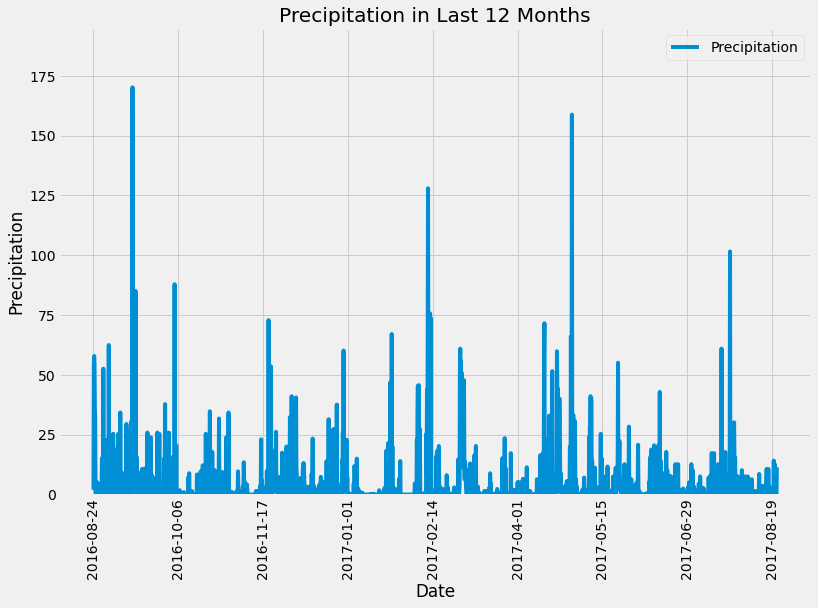

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data

date_prcp_df.plot(figsize = (12, 8))

plt.title("Precipitation in Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation")

plt.ylim(0, 195)

plt.xticks(rotation = 90)

plt.legend(loc = "upper right")

plt.savefig("Images/Precipitation in Last 12 Months.png")

plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data

date_prcp_df.describe()

,Precipitation
count,2015.000000
mean,4.485112
std,11.690532
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset

session.query(Station.id).count()

9

In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

sel = [Measurement.station, func.count(Measurement.id)]

active_stations = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station = active_stations[0][0]

sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

result = session.query(*sel).filter(Measurement.station == most_active_station).one()

print(f"The lowest temperature observed at {most_active_station} is {result[0]}")

print(f"The highest temperature observed at {most_active_station} is {result[1]}")

print(f"The average temperature observed at {most_active_station} is {round(result[2], 1)}")

The lowest temperature observed at USC00519281 is 12.2
The highest temperature observed at USC00519281 is 29.4
The average temperature observed at USC00519281 is 22.0


In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station

sel = Measurement.date, Measurement.tobs
tobs = session.query(*sel).filter(Measurement.station == most_active_station).\
        filter(Measurement.date >= last_twelve_months).all()

tobs_df = pd.DataFrame(tobs, columns = ["Date", "TOBS"])

tobs_df.set_index("Date", inplace=True)

tobs_df.head()

,TOBS
Date,
2016-08-24,25.0
2016-08-25,26.7
2016-08-26,26.7
2016-08-27,23.9
2016-08-28,22.8


<function matplotlib.pyplot.show(*args, **kw)>

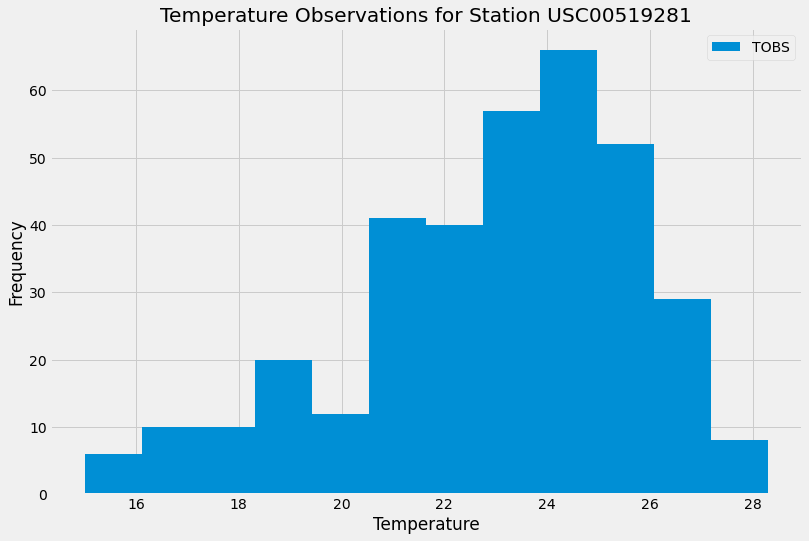

In [21]:
# Plot the results as a histogram

tobs_df.plot.hist("TOBS", bins = 12,  figsize = (12, 8))

plt.grid(True)

plt.title("Temperature Observations for Station " + most_active_station)

plt.xlabel("Temperature")

plt.legend(loc = "upper right")

plt.savefig("Images/Temperature Observations.png")

plt.show

# Close session

In [22]:
# Close Session

session.close()